In [21]:
# Setup scenario
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd

from climada.engine import CostBenefit, Impact, ImpactCalc
from climada.engine.cost_benefit import risk_aai_agg
from climada.entity import DiscRates, Entity, Exposures, LitPop
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet, ImpfTropCyclone
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone
from climada.entity.measures import Measure, MeasureSet
from climada.hazard import Hazard
from climada.util.api_client import Client

import handlers
from handlers import calculate_impact, calculate_impact_function_set
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])


notebook_dir = %pwd

# Go up one directory
BASE_DIR = Path(notebook_dir).parent

# Define the paths for exposures and hazards
DATA_DIR = BASE_DIR / "data"
EXPOSURES_DIR = BASE_DIR / "data" / "exposures"
HAZARDS_DIR = BASE_DIR / "data" / "hazards"
REQUIREMENTS_DIR = BASE_DIR / "requirements"
GADM41_EGY_PATH = REQUIREMENTS_DIR / "gadm41_EGY.gpkg"
GADM41_THA_PATH = REQUIREMENTS_DIR / "gadm41_THA.gpkg"
DATA_TEMP_DIR = DATA_DIR / "temp" 
ENTITIES_DIR = BASE_DIR / "data" / "entities"

# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"        # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "river_flood"     # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
scenario = "rcp26" # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
time_horizon = "2030_2050"      # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070'] / 
annual_growth = 1.02

client = Client()

In [ ]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [
    data_type_info.data_type for data_type_info in data_type_infos if data_type_info.data_type_group == 'exposures']
hazard_data_types = [
    data_type_info.data_type for data_type_info in data_type_infos if data_type_info.data_type_group == 'hazard']

print(
    f'Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}')
print(
    f'Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}')

In [ ]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        'country_name': country_name,
    }
)

exposure_data_types = list(set(
    [dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'exposures']))
hazard_data_types = list(set(
    [dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'hazard']))

print(
    f'Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}')
print(
    f'Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}')

In [ ]:
if hazard_type == 'river_flood' or 'wildfire':
    available_scenarios = list(set([dataset_info.properties['climate_scenario']
                               for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
    available_time_horizons = list(set([dataset_info.properties['year_range']
                                   for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
if hazard_type == 'tropical_cyclone':
    available_scenarios = list(set([dataset_info.properties['climate_scenario']
                               for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
    available_time_horizons = list(set([dataset_info.properties.get(
        'ref_year') for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
if hazard_type == 'earthquake':
    available_scenarios = []
    available_time_horizons = []
if hazard_type == 'flood':
    available_scenarios = []
    available_time_horizons = list(set([dataset_info.properties['year_range']
                                   for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))

print(
    f'Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}')
print(
    f'Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}')

In [ ]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        "data_type": hazard_type,
        "country_name": country_name,
        # "climate_scenario": climate_scenario,
    }
)
hazard_dataset_infos

In [2]:
# Get Exposure
# Available Exposures: ['litpop']
exposure_present = handlers.get_exposure(country_name)
if annual_growth > 1:
    exposure_future = handlers.get_growth_exposure(exposure_present, annual_growth, 2040)

In [3]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']
ref_year = handlers.get_hazard_time_horizon(hazard_type, scenario, country_name)
hazard_present = handlers.get_hazard(
    hazard_type,
    "historical",
    "1980_2000",
    country_name,
)

if scenario != "historical":
    hazard_future = handlers.get_hazard(
        hazard_type,
        scenario,
        "2030_2050",
        country_name,
    )

In [7]:
# Get Impact
impact_function_set = calculate_impact_function_set(hazard_present)
impact_present = calculate_impact(exposure_present, hazard_present, impact_function_set)
if scenario != "historical":
    if annual_growth > 1:
        impact_future = calculate_impact(exposure_future, hazard_future, impact_function_set)
    impact_future = calculate_impact(exposure_present, hazard_future, impact_function_set)

In [ ]:
def get_measure_(hazard: Hazard, name: str = "", cost: int = 0) -> Measure:
    return Measure(haz_type=hazard.haz_type, name=name, cost=cost)



In [80]:
measure_set = MeasureSet.from_excel(ENTITIES_DIR / "entity_template.xlsx")


{'TC': ['beach nourishment',
  'vegetation management',
  'enforce building code',
  'risk transfer'],
 'TS': ['sandbags', 'seawall', 'elevate existing buildings']}

In [68]:
# Define adaptation measures
measure1 = Measure(
    haz_type="RF",
    name="Measure A",  # name of the measure
    color_rgb=np.array([0.8, 0.1, 0.1]), # integer array of size 3. Color code of this measure in RGB
    cost=5000000,  # discounted cost (in same units as assets)
    hazard_inten_imp=(1, -1),
)

measure2 = Measure(
    haz_type='RF',
    name='Measure B',
    color_rgb=np.array([0.1, 0.1, 0.8]),
    cost=500000,
    paa_impact=(1, -0.10),   # 10% fewer assets affected
)

# gather all measures
measure_set = MeasureSet(measure_list=[measure1, measure2])
measure_set.check()

In [69]:
measure3 = Measure(
    haz_type="RF",
    name="Measure C",
    color_rgb=np.array([0.8, 0.1, 0.1]),
)
measure_set3 = MeasureSet(
    measure_list=[measure3],
)
measure_set3.check()

In [70]:
# Define discount rates
year_range = np.arange(exposure_present.ref_year, exposure_future.ref_year + 1)
n_years = exposure_future.ref_year - exposure_present.ref_year + 1
annual_discount_zero = np.zeros(n_years)
annual_discount_stern = np.ones(n_years) * 0.014

discount_zero = DiscRates(year_range, annual_discount_zero)
discount_stern = DiscRates(year_range, annual_discount_stern)

In [71]:
# Create Entity objects
entity_present = Entity(
    exposures=exposure_present,
    disc_rates=discount_zero,
    impact_func_set=impact_function_set,
    measure_set=measure_set,
)
entity_future = Entity(
    exposures=exposure_future,
    disc_rates=discount_zero,
    impact_func_set=impact_function_set,
    measure_set=measure_set,
)


Measure      Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
---------  ---------------  ------------------  --------------
Measure A           0.005              3.11734         623.469
Measure B           0.0005             2.50237        5004.74

--------------------  --------  --------
Total climate risk:   25.0237   (USD bn)
Average annual risk:   1.08799  (USD bn)
Residual risk:        19.404    (USD bn)
--------------------  --------  --------
Net Present Values


<AxesSubplot:xlabel='Return Period (2040)', ylabel='Impact (USD)'>

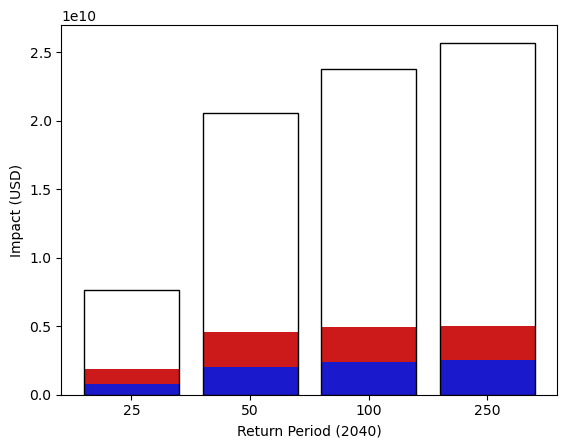

In [72]:
# Calculate cost-benefit
costben_measures_only = CostBenefit()
costben_measures_only.calc(hazard_present, entity_present, haz_future=None, ent_future=None,
                           future_year=2040, risk_func=risk_aai_agg, imp_time_depen=None, save_imp=True)

costben_measures_only.plot_event_view((25, 50, 100, 250))

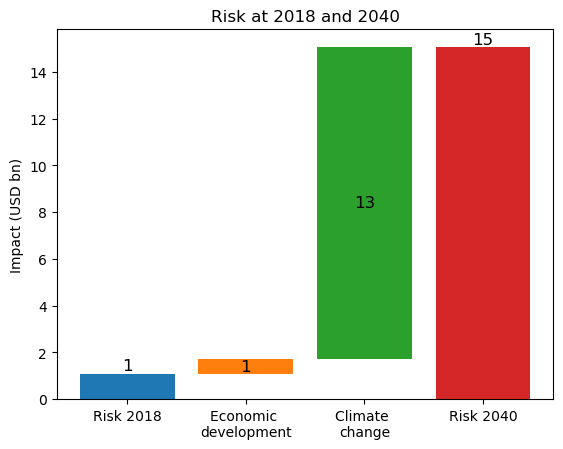

In [73]:
# define this as a function because we'll use it again later
def waterfall():
  return costben_measures_only.plot_waterfall(hazard_present, entity_present, hazard_future, entity_future,
                                risk_func=risk_aai_agg)

ax = waterfall()

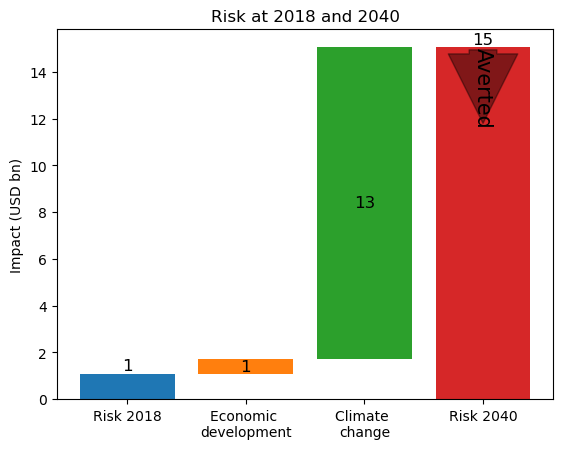

In [74]:
costben_measures_only.plot_arrow_averted(axis = waterfall(), in_meas_names=['Measure A', 'Measure B'], accumulate=True, combine=False,
                           risk_func=risk_aai_agg, disc_rates=None, imp_time_depen=1)

<AxesSubplot:title={'center':'RF 3: Flood Africa JRC Residential'}, xlabel='Intensity (m)', ylabel='Impact (%)'>

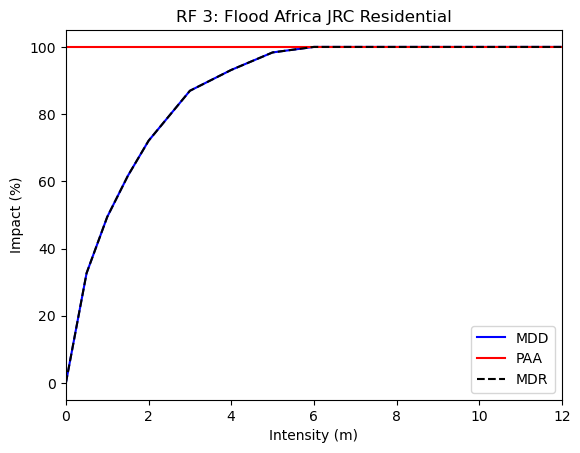

In [76]:
impact_function_set.plot()